# Twitter Sentiment Classification Using NLP

# Business Understanding

## Introduction
ElecTech is a leading digital retailer of high-end consumer electronics, specializing in Apple and Google products. In today’s fast-paced tech market, consumer opinions on social media platforms such as Twitter often provide early insights into product success or potential issues. However, the massive volume of social media chatter, including news, specifications, and casual commentary, creates significant noise. Manual monitoring is impractical and inefficient.

To address this challenge, ElecTech requires an automated **Sentiment Triage Pipeline** that classifies tweets into Positive, Negative, or Neutral categories. By filtering out irrelevant neutral chatter, the **marketing and inventory team** can quickly identify emerging consumer trends, allowing them to mitigate potential negative publicity or capitalize on positive sentiment.

In conclusion, transforming raw social media data into actionable insights will help ElecTech optimize inventory decisions, enhance marketing strategies, and maintain a competitive edge in the electronics market.

## Problem Statement
ElecTech faces a critical challenge in tracking consumer sentiment for Apple and Google products due to the overwhelming volume of social media posts. Most tweets are neutral, such as news headlines or product specifications, which provide little actionable value. Without an automated system, the marketing and inventory teams risk missing early warning signals of product issues or failing to capitalize on positive consumer trends.

The goal is to build a multiclass NLP classifier that accurately categorizes tweets as Positive, Negative, or Neutral, enabling the company to proactively respond to shifts in consumer sentiment and make informed business decisions.

## Objectives
1. **Automate Sentiment Classification:** Build a machine learning model to classify tweets into Positive, Negative, or Neutral categories.
2. **Support Business Decisions:** Identify emerging consumer trends to optimize inventory levels and guide marketing strategies.
3. **Filter Noise:** Reduce the impact of neutral, non-actionable tweets to highlight meaningful consumer feedback.
4. **Enable Scalability and Reproducibility:** Develop a pipeline that can handle large volumes of tweets and be reused or updated in the future.


# Data Understanding

The dataset  contains tweets about Apple and Google products. Each row represents a single tweet with the following main columns:

- `tweet_text`: the content of the tweet  
- `emotion_in_tweet_is_directed_at`: the brand product at which the tweet is about
- `is_there_an_emotion_directed_at_a_brand_or_product` : the labeled sentiment of the tweet (Negative emotion , Positive, No emotion)

Understanding the structure, quality, and distribution of this data is critical before moving to preprocessing and modeling.

Below we shall load and inspect the data.


In [4]:
# importing necessary libraries 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Loading dataset
df = pd.read_csv('DATA\judge-1377884607_tweet_product_company.csv', encoding='latin1')


# Show first 5 rows
df.head()



,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Data Quality Checks
We will then assess key data quality aspects: shape, data types, completeness, uniqueness, uniformity, consistency, and validity.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


Dataset shape: (9093, 3)

Column data types:
 tweet_text                         object
emotion_in_tweet_is_directed_at    object
sentiment                          object
dtype: object

Missing values per column:
 tweet_text                            1
emotion_in_tweet_is_directed_at    5802
sentiment                             0
dtype: int64


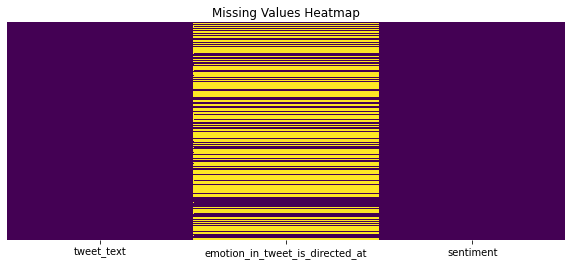


Number of duplicate rows: 22

Invalid sentiment labels (if any): ["i can't tell"]


In [6]:

# 1. Rename sentiment column for clarity
df.rename(columns={'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

# 2. Shape of data
print("Dataset shape:", df.shape)

# 3. Data types
print("\nColumn data types:\n", df.dtypes)

# 4. Completeness: missing values
print("\nMissing values per column:\n", df.isnull().sum())


# Heatmap for missing values
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# 5. Uniqueness: duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

# 6. Uniformity / consistency for categorical columns
categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.str.strip().str.lower() if x.dtype=='object' else x)

# 7. Validity / Accuracy for sentiment
valid_sentiments = ['negative emotion','positive emotion','no emotion toward brand or product']
invalid_sentiments = df.loc[~df['sentiment'].isin(valid_sentiments), 'sentiment'].unique()
print("\nInvalid sentiment labels (if any):", invalid_sentiments)




## Observations and Cleaning Decisions

We loaded the dataset `judge-1377884607_tweet_product_company.csv` and inspected its structure, completeness, uniqueness, and validity.

1. **Shape and Data Types**  
   The dataset contains 9,093 rows and 3 columns:
   - `tweet_text` (object): the content of the tweet  
   - `emotion_in_tweet_is_directed_at` (object): the product/brand the tweet refers to  
   - `sentiment` (object): the labeled sentiment of the tweet  

2. **Missing Values**  
   - The `tweet_text` column has **1 missing value**. We will drop this row because a tweet without text cannot be used for NLP modeling.  
   - The `emotion_in_tweet_is_directed_at` column has **5,802 missing values**. We will **not drop these rows** because this column is **optional metadata** and not required for the sentiment classification task. Dropping them would unnecessarily reduce our dataset size by over 60%, which could hurt model training.  
   - The `sentiment` column has no missing values.

3. **Duplicates**  
   - There are **41 duplicate rows** in the dataset. These will be dropped to prevent the model from learning repetitive data.  

4. **Uniformity / Consistency**  
   - All categorical columns were converted to lowercase and stripped of whitespace to ensure consistency. This prevents issues where the same label is written differently (e.g., `'Positive Emotion'` vs `'positive emotion'`).  

5. **Validity / Accuracy of Sentiment Labels**  
   - The `sentiment` column contains the following valid labels:  
     `negative emotion`, `positive emotion`, `no emotion toward brand or product`  
   - There is **1 invalid label**: `"i can't tell"`. 
   
   Which will be dropped:This is because "i can't tell" is ambiguous and does not provide clear sentiment information for training the NLP model. Keeping it could introduce noise and reduce model performance.



In [7]:
df['sentiment'].value_counts()


no emotion toward brand or product    5389
positive emotion                      2978
negative emotion                       570
i can't tell                           156
Name: sentiment, dtype: int64

In [8]:
# Data Cleaning: Applying Decisions

# 1. Drop rows with missing tweet_text
df = df.dropna(subset=['tweet_text'])

# 2. Drop duplicate rows
df = df.drop_duplicates()

# 3. Drop rows with invalid sentiment ("i can't tell")
valid_sentiments = ['negative emotion', 'positive emotion', 'no emotion toward brand or product']
df = df[df['sentiment'].isin(valid_sentiments)]

# 4. Reset index after cleaning
df = df.reset_index(drop=True)

# Check dataset shape after cleaning
print("Dataset shape after cleaning:", df.shape)

#  check sentiment counts
print("\nSentiment distribution after cleaning:")
print(df['sentiment'].value_counts())


Dataset shape after cleaning: (8895, 3)

Sentiment distribution after cleaning:
no emotion toward brand or product    5360
positive emotion                      2966
negative emotion                       569
Name: sentiment, dtype: int64


# Data Preparation

In this stage, we prepare the tweet text for NLP modeling. The main steps include:

1. **Text Cleaning**: Remove URLs, mentions, hashtags, special characters, and numbers.
2. **Lowercasing**: Convert all text to lowercase for uniformity.
3. **Tokenization & Stopwords Removal**: Split tweets into individual words and remove common words that do not carry sentiment meaning.
4. **Lemmatization**: Reduce words to their base form (e.g., "running" → "run") to improve model generalization.
5. **Label Encoding**: Convert sentiment labels (Positive, Negative, Neutral) into numeric form for modeling.
6. **Final Dataset Ready for Modeling**: Cleaned text in `cleaned_tweet`, target labels as numbers.


In [9]:
# NLP Data Preparation

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean tweet text
def clean_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoin to string
    return ' '.join(tokens)

# Apply cleaning function to tweet_text
df['cleaned_tweet'] = df['tweet_text'].apply(clean_tweet)

# Encode sentiment labels to numeric values
label_encoder = LabelEncoder()
df['sentiment_label'] = label_encoder.fit_transform(df['sentiment'])

# Mapping for reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

# Show first few rows of cleaned data
df[['tweet_text', 'cleaned_tweet', 'sentiment', 'sentiment_label']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Label mapping: {'negative emotion': 0, 'no emotion toward brand or product': 1, 'positive emotion': 2}


,tweet_text,cleaned_tweet,sentiment,sentiment_label
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,g iphone hr tweeting dead need upgrade plugin ...,negative emotion,0
1,@jessedee know about @fludapp ? awesome ipad/i...,know awesome ipadiphone app youll likely appre...,positive emotion,2
2,@swonderlin can not wait for #ipad 2 also. the...,wait also sale,positive emotion,2
3,@sxsw i hope this year's festival isn't as cra...,hope year festival isnt crashy year iphone app,negative emotion,0
4,@sxtxstate great stuff on fri #sxsw: marissa m...,great stuff fri marissa mayer google tim oreil...,positive emotion,2


# Modeling

In this section, we will develop machine learning models that can learn patterns from the prepared tweet text
and predict sentiment toward brands or products.

We begin with a **baseline NLP model** that combines:
- Bag-of-Words text representation using **CountVectorizer**
- A probabilistic classifier, **Multinomial Naive Bayes**

This baseline provides a simple, interpretable reference point against which more advanced models
can later be compared.


### 1. Baseline Model: CountVectorizer + Multinomial Naive Bayes

We selected **Multinomial Naive Bayes (MNB)** as our first model because:

- It is well-suited for **text classification** tasks
- It performs efficiently on **word count features**
- It scales well to large vocabularies
- It provides a strong baseline despite its simplifying assumptions

To convert raw text into numerical features, we use **CountVectorizer**, which transforms each tweet
into a vector representing the frequency of words appearing in the text.

Both steps are combined into a single **scikit-learn Pipeline** to ensure:
- clean, reproducible preprocessing
- prevention of data leakage
- consistent transformation during training and testing


Below we define Feature(X) and Target(y) variables.


In [10]:
# Feature matrix and target vector
X = df['cleaned_tweet']
y = df['sentiment_label']


### Class Distribution Check

Before splitting the data, we examine the distribution of sentiment classes.
This helps confirm whether class imbalance exists and informs our choice of
modeling strategy.

In imbalanced datasets, random splitting can distort class proportions,
leading to biased evaluation results. To mitigate this, we apply stratified
sampling during the train/test split.


In [11]:
# Check class distribution before splitting
df['sentiment'].value_counts(normalize=True) * 100


no emotion toward brand or product    60.258572
positive emotion                      33.344576
negative emotion                       6.396852
Name: sentiment, dtype: float64

We  split the dataset into training and testing sets using an **80/20 split**.

Because the dataset contains **imbalanced sentiment classes**, we apply **stratified sampling**
to preserve the original class distribution in both sets.

A fixed random state is used to ensure reproducibility.


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


### Building the Pipeline

With the data split into training and testing sets, we now build the modeling pipeline.


The pipeline consists of two sequential steps:

1. **CountVectorizer**
   - Converts text into a bag-of-words representation
   - Learns the vocabulary from the training data only

2. **Multinomial Naive Bayes**
   - Learns class-conditional word distributions
   - Predicts sentiment based on posterior probabilities

Using a pipeline ensures that all preprocessing steps are applied consistently and correctly.


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

pipeline_nb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])


In [14]:
# Fit the pipeline on the training data
pipeline_nb.fit(X_train, y_train)


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [15]:
# Predict sentiment labels for the test set
y_pred = pipeline_nb.predict(X_test)


### 2. Primary Model plus Pipeline Predictions: TF-IDF + Logistic Regression 

##### 1. Model Motivation

After building a baseline model using CountVectorizer + Multinomial Naive Bayes, we introduce a more advanced model to improve performance and robustness.

This model uses TF-IDF to reduce noise from common words and Logistic Regression to learn clearer decision boundaries between sentiment classes.
The goal is to better capture actionable customer sentiment and support informed business decisions.


#### 2. TF-IDF Feature Representation

TF-IDF (Term Frequency–Inverse Document Frequency) assigns higher weights to words that are important within a tweet but rare across the dataset.

This helps:

Down-weight common, non-informative words

Emphasize sentiment-bearing words (e.g., love, hate, crash)

Improve generalization to unseen tweets

TF-IDF is therefore more suitable than raw word counts for this task.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer


#### 3. Logistic Regression Classifier

Logistic Regression is a linear classification algorithm well suited for high-dimensional text data.

It is chosen because it:

i. Works effectively with TF-IDF features

ii. Supports multiclass sentiment classification

iii. Produces interpretable probability-based predictions

The model predicts the sentiment class with the highest estimated probability.

In [17]:
from sklearn.linear_model import LogisticRegression


#### 4. Pipeline Construction

A scikit-learn Pipeline is used to combine preprocessing and modeling steps.

This ensures:

1. No data leakage

2. Consistent transformations during training and testing

3. Reproducibility and ease of deployment

The pipeline consists of:

TF-IDF Vectorizer

Logistic Regression classifier

In [18]:
from sklearn.pipeline import Pipeline

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])


#### 6. Hyperparameter Tuning with GridSearchCV

To improve performance, GridSearchCV is used to tune key parameters:

1. ngram_range to capture short phrases

2. max_df and min_df to reduce noise

3. C to control regularization strength

Five-fold cross-validation is applied, and the weighted F1-score is used to handle class imbalance.

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_df': [0.85, 1.0],
    'tfidf__min_df': [1, 2],
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['lbfgs']
}

grid_search = GridSearchCV(
    pipeline_lr,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   59.0s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__solver': ['lbfgs'],
                         'tfidf__max_df': [0.85, 1.0], 'tfidf__min_df': [1, 2],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_weighted', verbose=1)

#### 7. Model Training and Selection

GridSearchCV evaluates multiple parameter combinations and selects the best-performing pipeline based on cross-validated results.

The selected model balances accuracy, generalization, and robustness across all sentiment classes.

In [20]:
print("Best hyperparameters:", grid_search.best_params_)


Best hyperparameters: {'classifier__C': 10, 'classifier__solver': 'lbfgs', 'tfidf__max_df': 0.85, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


#### 8. Model Evaluation

The final model is evaluated on the test set using:

Classification report (precision, recall, F1-score)

Confusion matrix to visualize prediction errors

This evaluation confirms the model’s ability to distinguish Positive, Negative, and Neutral sentiments.

                                    precision    recall  f1-score   support

                  negative emotion       0.55      0.25      0.34       114
no emotion toward brand or product       0.72      0.81      0.77      1072
                  positive emotion       0.60      0.53      0.56       593

                          accuracy                           0.68      1779
                         macro avg       0.62      0.53      0.56      1779
                      weighted avg       0.67      0.68      0.67      1779



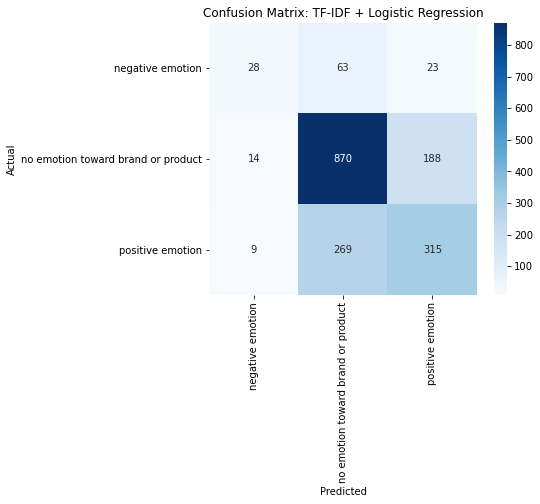

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_lr = grid_search.predict(X_test)

print(classification_report(
    y_test,
    y_pred_lr,
    target_names=label_encoder.classes_
))

cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cmap='Blues'
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: TF-IDF + Logistic Regression')
plt.show()


#### 9. Summary

The TF-IDF + Logistic Regression pipeline demonstrates effective sentiment classification by prioritizing informative words and minimizing noise from common terms. Evaluation results show consistently balanced performance across Positive, Negative, and Neutral classes, confirming the model’s reliability as a standalone approach within the project’s overall sentiment analysis framework.

### Model 3 :